[BeautifulSoup](https://pypi.org/project/beautifulsoup4/) 

**Version:** 0.5
<p>**Description:** Adding the Banks (Angola) MX Records to the dataset</p>

This code uses the dns.resolver module from dnspython to retrieve the MX records for each naked domain. The MX records are stored in the "mx_records" column of the CSV file.

This updated code handles common exceptions related to DNS resolution, such as NXDOMAIN, NoNameservers, and NoAnswer. Additionally, it captures any other DNSException and includes the error message in the mx_records field.

In [1]:
!pip3 install dnspython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 5.7 MB/s eta 0:00:00


In [2]:
!pip install python-whois

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for python-whois: filename=python_whois-0.8.0-py3-none-any.whl size=103263 sha256=bdb05888681bf897cc6dfc85f666139b2d1234d22df19b1d99fcead3c1c83034
  Stored in directory: /root/.cache/pip/wheels/10/f1/87/145023b9a206e2e948be6480c61ef3fd3dbb81ef11b6977782
Successfully built python-whois


In [3]:
import csv
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import dns.resolver
import requests
import whois

# Send a GET request to the webpage
url = "https://www.abanc.ao/sistema-financeiro/instituicoes-bancarias-autorizadas/"
response = requests.get(url)

# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.content, "html.parser")

# Find all bank information div elements
bank_divs = soup.find_all("div", class_="cmsAccordion")

# Initialize an empty list to store the bank details
bank_details = []

# Iterate over each bank div
for bank_div in bank_divs:
    # Extract bank name
    bank_name = bank_div.find("p", class_="heading").text.strip()

    # Extract bank info divs
    bank_info_divs = bank_div.find_all("div", class_="content")

    # Extract bank website
    bank_website = None
    for bank_info_div in bank_info_divs:
        bank_website_element = bank_info_div.find("a")
        if bank_website_element:
            bank_website = bank_website_element["href"]
            break

    # If bank website is not found, check the second occurrence of class "content"
    if not bank_website and len(bank_info_divs) > 1:
        bank_info_div = bank_info_divs[1]
        bank_website_element = bank_info_div.find("a")
        if bank_website_element:
            bank_website = bank_website_element["href"]

    # Extract the naked domain from the bank website URL
    naked_domain = None
    if bank_website:
        parsed_url = urlparse(bank_website)
        netloc = parsed_url.netloc
        if netloc.startswith("www."):
            naked_domain = netloc[4:]  # Remove "www" part from the domain
        else:
            naked_domain = netloc

    # Retrieve MX records for the naked domain
    mx_records = None
    if naked_domain:
        try:
            answers = dns.resolver.resolve(naked_domain, "MX")
            mx_records = [str(r.exchange)[:-1] for r in answers]
        except (dns.resolver.NXDOMAIN, dns.resolver.NoNameservers, dns.resolver.NoAnswer):
            mx_records = "No MX records found"
        except dns.exception.DNSException as e:
            mx_records = f"Error: {str(e)}"

    # Perform DNS lookup on each MX record and perform whois lookup on the IP address
    org_names = []
    if mx_records and mx_records != "No MX records found":
        for mx_record in mx_records:
            try:
                answers = dns.resolver.resolve(mx_record, "A")
                ip_address = answers[0].address

                whois_info = whois.whois(ip_address)
                org_name = whois_info.get("org")
                if org_name:
                    org_names.append(org_name)

            except (dns.resolver.NXDOMAIN, dns.resolver.NoNameservers, dns.resolver.NoAnswer, whois.parser.PywhoisError):
                continue
            except dns.exception.DNSException as e:
                print(f"Error performing DNS lookup for {mx_record}: {str(e)}")
            except Exception as e:
                print(f"Error performing whois lookup for {ip_address}: {str(e)}")

    # Create a dictionary to store the bank details
    bank = {
        "name": bank_name,
        "website": bank_website,
        "naked_domain": naked_domain,
        "mx_records": mx_records,
        "org_names": org_names
    }

    # Append the bank details to the list
    bank_details.append(bank)

# Specify the output CSV file path
csv_file = "bank_details-5.0.1.csv"

# Write the bank details to the CSV file
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=["name", "website", "naked_domain", "mx_records", "org_names"])
    writer.writeheader()
    writer.writerows(bank_details)

print("Bank details written to", csv_file)

Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
Bank details written to bank_details-5.0.1.csv


***Version:*** 5.0.1

***Description:*** Plotting the info using the local dataset (Generated by the previous version of the code)

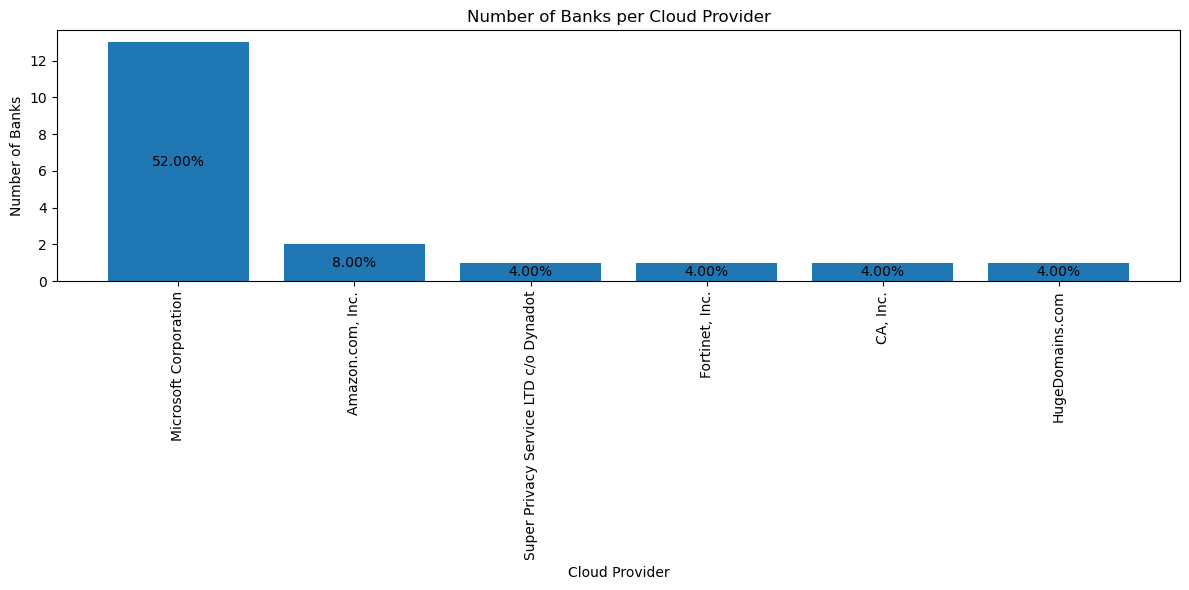

In [4]:
import csv
import ast
import matplotlib.pyplot as plt

# Specify the input CSV file path
csv_file = "/kaggle/input/bankdetails501/bank_details-5.0.1.csv"

# Read the bank details from the CSV file
bank_details = []
with open(csv_file, "r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    for row in reader:
        row["org_names"] = ast.literal_eval(row["org_names"])
        bank_details.append(row)

# Count the unique occurrences of each org_name
org_name_counts = {}
for bank in bank_details:
    org_names = bank["org_names"]
    unique_org_names = set(org_names)  # Remove duplicates within a row
    for org_name in unique_org_names:
        org_name = org_name.strip("'")  # Remove the single quotes from the Org Name
        if org_name in org_name_counts:
            org_name_counts[org_name] += 1
        else:
            org_name_counts[org_name] = 1

# Sort the org_name_counts by count in descending order
sorted_org_name_counts = sorted(org_name_counts.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
org_names = [item[0] for item in sorted_org_name_counts]
counts = [item[1] for item in sorted_org_name_counts]

# Calculate total number of banks
total_banks = len(bank_details)

# Calculate percentage for each org_name
percentages = [(count / total_banks) * 100 for _, count in sorted_org_name_counts]

# Plot the bar chart with percentage annotations
plt.figure(figsize=(12, 6))
bars = plt.bar(org_names, counts)
plt.xlabel("Cloud Provider")
plt.ylabel("Number of Banks")
plt.title("Number of Banks per Cloud Provider")
plt.xticks(rotation=90)
plt.tight_layout()

# Add percentage annotations inside each bar
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{percentage:.2f}%", ha='center', va='center')

plt.show()